In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import f1_score

from nn import NN
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
X = np.load('../data/x_train_shuffled.npy')
Y = np.load('../data/y_train_shuffled.npy')
Y = np.array([1 if x == 'A' else 0 for x in Y])
print(X.shape, Y.shape)

(17023, 6000, 1) (17023,)


In [3]:
test_num = val_num = 3000
X_test = X[:test_num]
Y_test = Y[:test_num]
X_val = X[test_num:test_num+val_num]
Y_val = Y[test_num:test_num+val_num]
X_train = X[test_num+val_num:]
Y_train = Y[test_num+val_num:]
print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape)

(11023, 6000, 1) (11023,) (3000, 6000, 1) (3000,) (3000, 6000, 1) (3000,)


In [4]:
input_shape = X_train.shape[1:]
units = 128

In [5]:
# Construct deep network (ResNet + GRU)
inputs = keras.Input(shape=input_shape)
network = NN('apnea_ecg_ResNet_plus_RNN.json')
outputs = network.build(inputs)
outputs = keras.layers.Bidirectional(keras.layers.GRU(units, return_sequences=True))(outputs)
outputs = keras.layers.Bidirectional(keras.layers.GRU(units, return_sequences=False))(outputs)
outputs = keras.layers.Dense(1, activation='sigmoid')(outputs)

In [6]:
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6000, 1)]    0                                            
__________________________________________________________________________________________________
zero_padding1d (ZeroPadding1D)  (None, 6010, 1)      0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 3001, 64)     704         zero_padding1d[0][0]             
__________________________________________________________________________________________________
zero_padding1d_1 (ZeroPadding1D (None, 3005, 64)     0           conv1d[0][0]                     
______________________________________________________________________________________________

In [7]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['acc'])

In [8]:
history = model.fit(X_train, Y_train,
                    callbacks=[keras.callbacks.EarlyStopping(patience=5, restore_best_weights=False)],
                    validation_data=(X_val, Y_val), batch_size=32, epochs=100)

Train on 11023 samples, validate on 3000 samples
Epoch 1/100
11023/11023 [==============================] - 199s 18ms/sample - loss: 0.4992 - acc: 0.7535 - val_loss: 0.9349 - val_acc: 0.5157
Epoch 2/100
11023/11023 [==============================] - 180s 16ms/sample - loss: 0.3785 - acc: 0.8361 - val_loss: 0.3934 - val_acc: 0.8270
Epoch 3/100
11023/11023 [==============================] - 179s 16ms/sample - loss: 0.3428 - acc: 0.8492 - val_loss: 0.3195 - val_acc: 0.8657
Epoch 4/100
11023/11023 [==============================] - 179s 16ms/sample - loss: 0.3201 - acc: 0.8607 - val_loss: 0.3140 - val_acc: 0.8647
Epoch 5/100
11023/11023 [==============================] - 179s 16ms/sample - loss: 0.3121 - acc: 0.8640 - val_loss: 0.2880 - val_acc: 0.8750
Epoch 6/100
11023/11023 [==============================] - 179s 16ms/sample - loss: 0.2897 - acc: 0.8750 - val_loss: 0.2893 - val_acc: 0.8757
Epoch 7/100
11023/11023 [==============================] - 179s 16ms/sample - loss: 0.2717 - acc: 0

In [9]:
model.save('models/apnea_ecg_ResNet_plus_RNN.h5')

In [10]:
# verify test data set
score = model.evaluate(X_test, Y_test)

3000/3000 [==============================] - 14s 5ms/sample - loss: 0.2024 - acc: 0.9240


In [12]:
preds = model.predict(X_test)
labels = preds > 0.5

In [13]:
# calculate f1 score for test data set
f1_macro = f1_score(Y_test, labels.astype(int), average='macro')
f1_micro = f1_score(Y_test, labels.astype(int), average='micro')
print(f1_macro, f1_micro)

0.9197028913063587 0.924


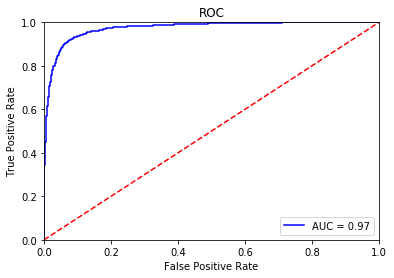

In [14]:
# plot AUC for test data set
import sklearn.metrics as metrics

fpr, tpr, th = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.title('ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

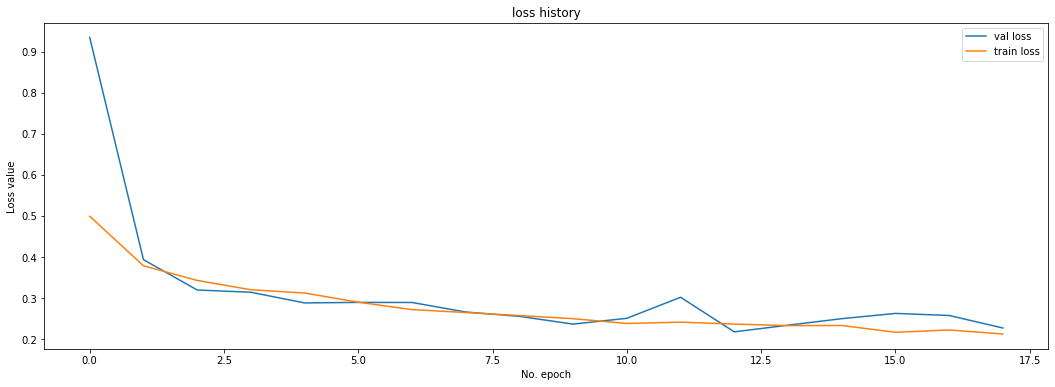

In [15]:
# plot loss history
fig, ax = plt.subplots()
fig.set_size_inches(18, 6)
ax.plot(history.history['val_loss'], label='val loss')
ax.plot(history.history['loss'], label='train loss')
plt.title('loss history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc='best')
plt.show()

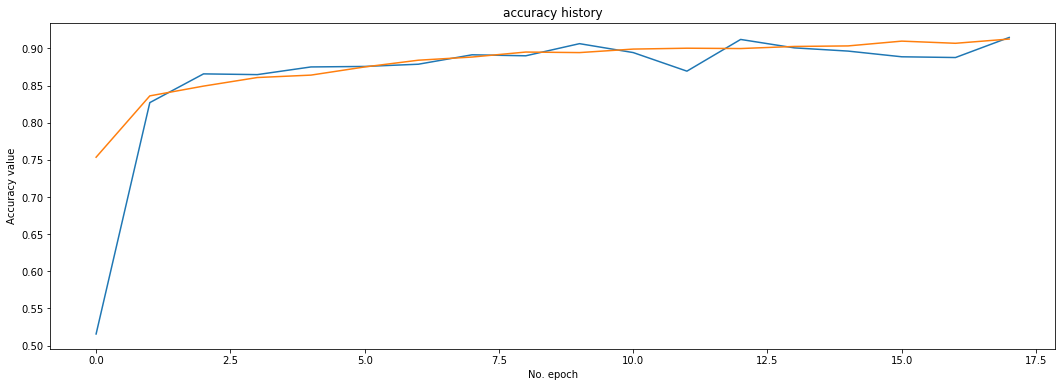

In [16]:
# plot accuracy history
fig, ax = plt.subplots()
fig.set_size_inches(18, 6)
ax.plot(history.history['val_acc'], label='val acc')
ax.plot(history.history['acc'], label='train acc')
plt.title('accuracy history')
plt.ylabel('Accuracy value')
plt.xlabel('No. epoch')
plt.show()

In [ ]:
# TODO: explainable model